# 회귀 분석 모델 (Regression Model) - PyTorch

## 필요한 라이브러리 임포트

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 데이터 로드 및 전처리

In [3]:
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/diabetes.csv"
data = pd.read_csv(url)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# 데이터 기본 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# 데이터 통계 정보 확인
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# 특성과 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.astype(np.float32)  # 회귀 분석을 위해 float32로 변환

# 데이터 분할 (훈련 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PyTorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 회귀 분석을 위해 형태 변경
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # 회귀 분석을 위해 형태 변경

# 데이터 로더 생성
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 데이터 형태 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

## 회귀 모델 정의

In [7]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(8, 64)  # 입력 특성 수는 8
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 출력은 연속값 1개 (회귀)
        self.dropout = nn.Dropout(0.2)  # 과적합 방지를 위한 드롭아웃 추가
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 회귀 모델이므로 활성화 함수 없음
        return x

# 모델 초기화
model = RegressionModel()

## 손실 함수 및 최적화 기법 정의

In [8]:
# 회귀 분석을 위한 MSE 손실 함수 사용
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 모델 학습

In [9]:
# 학습 및 검증 손실 저장
train_losses = []
val_losses = []
val_r2_scores = []

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 에포크당 평균 손실 계산
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # 검증 데이터로 평가
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)
    
    # R² 점수 계산
    r2 = r2_score(all_targets, all_preds)
    val_r2_scores.append(r2)
    
    # 10 에포크마다 진행 상황 출력
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R² Score: {r2:.4f}')

print("학습 완료.")

Epoch 10/100, Train Loss: 0.1513, Val Loss: 0.1580, R² Score: 0.3084
Epoch 20/100, Train Loss: 0.1488, Val Loss: 0.1595, R² Score: 0.3032
Epoch 30/100, Train Loss: 0.1340, Val Loss: 0.1662, R² Score: 0.2730
Epoch 40/100, Train Loss: 0.1423, Val Loss: 0.1744, R² Score: 0.2379
Epoch 50/100, Train Loss: 0.1245, Val Loss: 0.1751, R² Score: 0.2340
Epoch 60/100, Train Loss: 0.1205, Val Loss: 0.1761, R² Score: 0.2314
Epoch 70/100, Train Loss: 0.1141, Val Loss: 0.1875, R² Score: 0.1806
Epoch 80/100, Train Loss: 0.1120, Val Loss: 0.1857, R² Score: 0.1901
Epoch 90/100, Train Loss: 0.1110, Val Loss: 0.1815, R² Score: 0.2086
Epoch 100/100, Train Loss: 0.0978, Val Loss: 0.1857, R² Score: 0.1888
학습 완료.


## 학습 결과 시각화

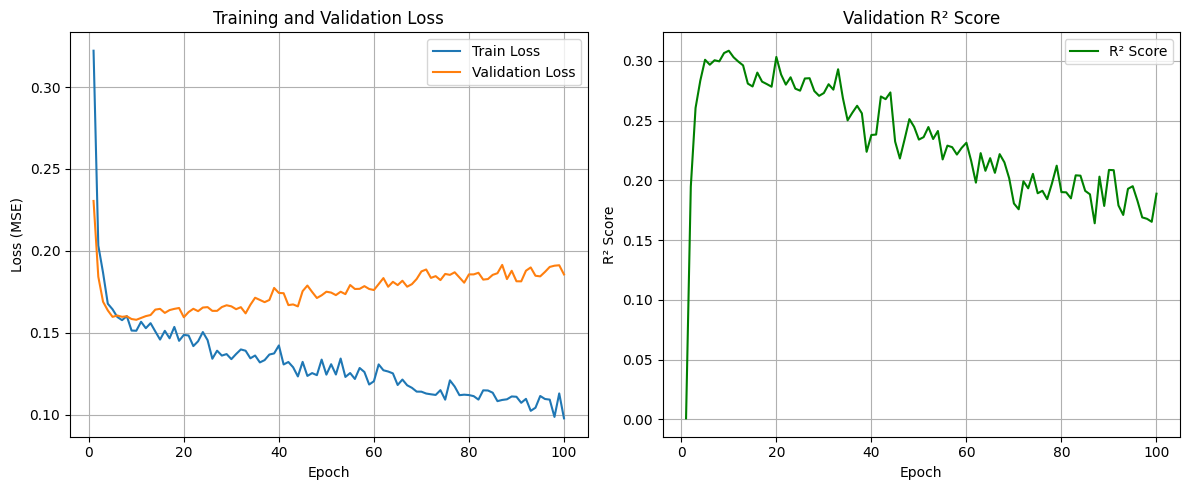

In [10]:
# 손실 그래프 그리기
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_r2_scores, label='R² Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 모델 평가

In [11]:
# 테스트 데이터에 대한 예측
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# 예측값과 실제값을 numpy 배열로 변환
all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

# 회귀 평가 지표 계산
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.1862
Root Mean Squared Error (RMSE): 0.4316
Mean Absolute Error (MAE): 0.3280
R² Score: 0.1888


C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51

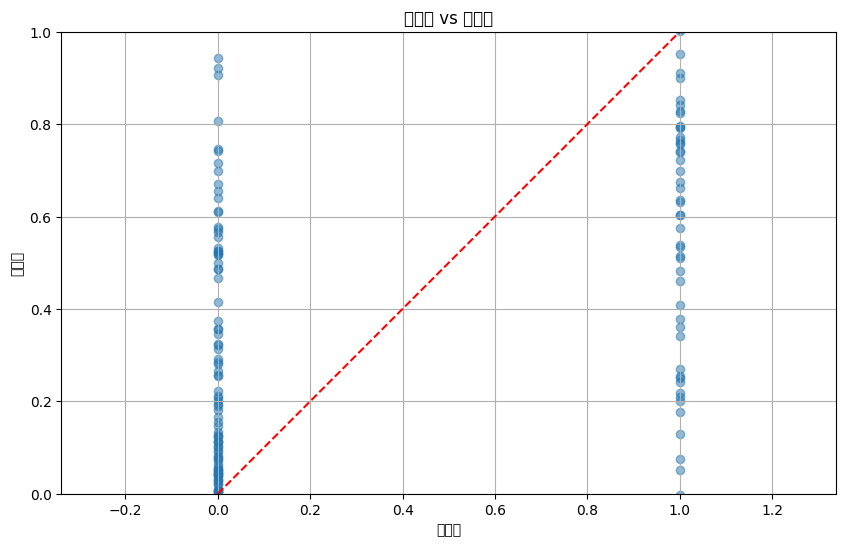

In [12]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('실제값 vs 예측값')
plt.grid(True)
plt.axis('equal')
plt.axis([0, 1, 0, 1])
plt.show()

## 예측 오차 분석

C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516

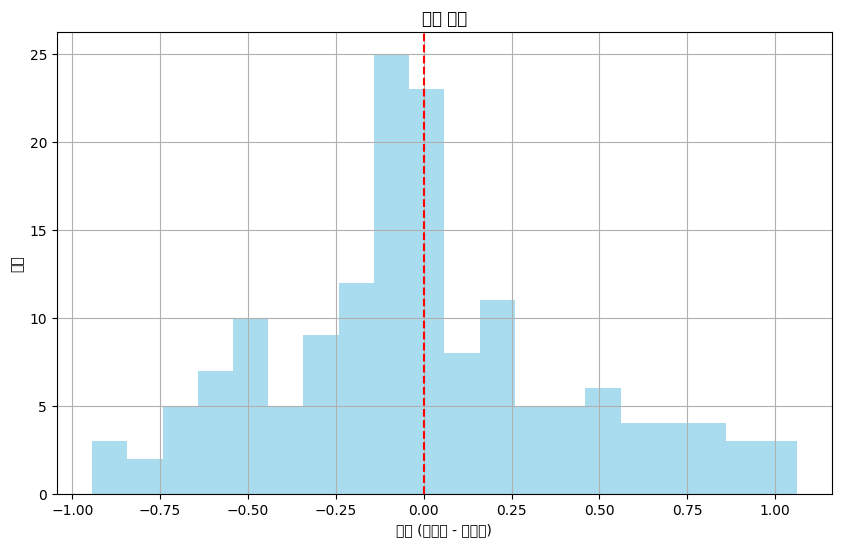

In [13]:
# 잔차(오차) 계산
residuals = all_targets - all_preds

# 잔차 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('잔차 (실제값 - 예측값)')
plt.ylabel('빈도')
plt.title('잔차 분포')
plt.grid(True)
plt.show()

C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


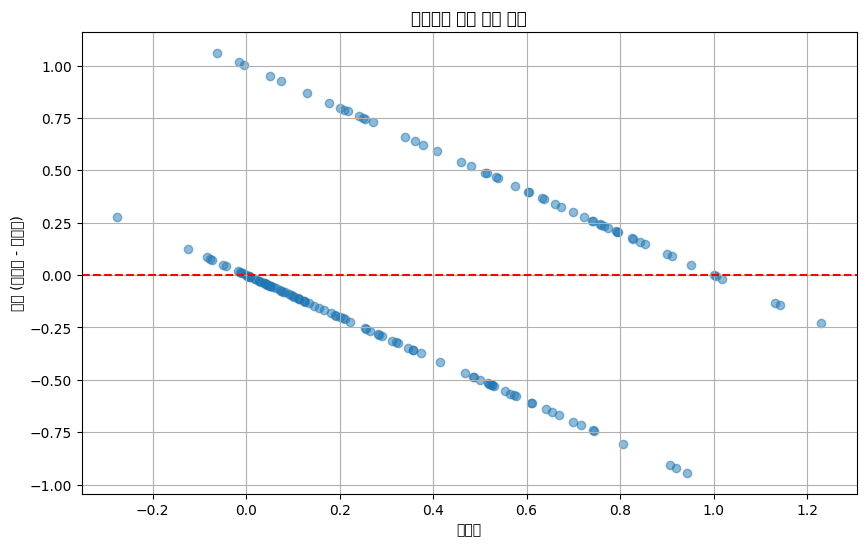

In [14]:
# 예측값에 따른 잔차 분포 (산점도)
plt.figure(figsize=(10, 6))
plt.scatter(all_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('예측값')
plt.ylabel('잔차 (실제값 - 예측값)')
plt.title('예측값에 따른 잔차 분포')
plt.grid(True)
plt.show()